In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
news_df = pd.read_csv('news.csv')
news_df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [3]:
news_df.shape

(6335, 4)

In [4]:
news_df.columns

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

In [5]:
news_df = news_df.drop(['title', 'Unnamed: 0'],axis=1)
news_df

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL
...,...,...
6330,The State Department told the Republican Natio...,REAL
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [6]:
news_df.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL


In [7]:
count = news_df['label'].value_counts()
count

REAL    3171
FAKE    3164
Name: label, dtype: int64

## Preprocessing the Text

In [8]:
#converting to lower case

news_df['text'] = news_df['text'].apply(lambda x: x.lower())
news_df['text'].head()

0    daniel greenfield, a shillman journalism fello...
1    google pinterest digg linkedin reddit stumbleu...
2    u.s. secretary of state john f. kerry said mon...
3    — kaydee king (@kaydeeking) november 9, 2016 t...
4    it's primary day in new york and front-runners...
Name: text, dtype: object

In [9]:
#removing punctuation

def string_preprocessing(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str=''.join(all_list)
    return clean_str

news_df['text'] = news_df['text'].apply(string_preprocessing)

In [10]:
#removing stopwords

from nltk.corpus import stopwords
stop = stopwords.words('english')
news_df['text']=news_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [11]:
news_df.head()

,text,label
0,daniel greenfield shillman journalism fellow f...,FAKE
1,google pinterest digg linkedin reddit stumbleu...,FAKE
2,us secretary state john f kerry said monday st...,REAL
3,— kaydee king kaydeeking november 9 2016 lesso...,FAKE
4,primary day new york frontrunners hillary clin...,REAL


## Exploratory Data Analysis

In [19]:
count = news_df['label'].value_counts()
count

REAL    3171
FAKE    3164
Name: label, dtype: int64

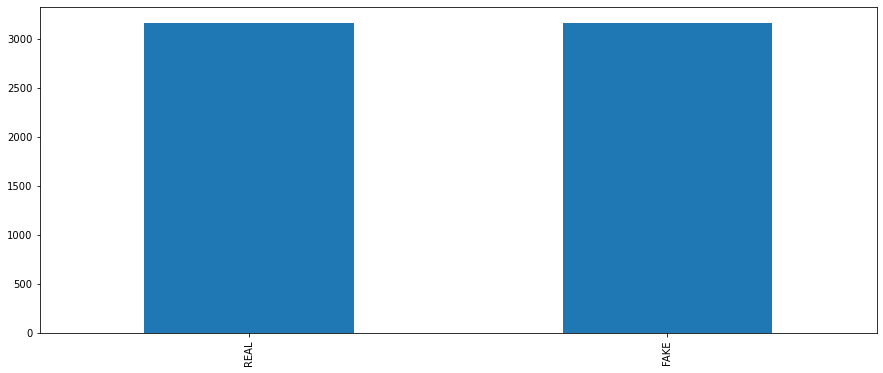

In [20]:
count.plot(kind='bar', figsize=(15,6))
plt.show()

In [21]:
import nltk
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

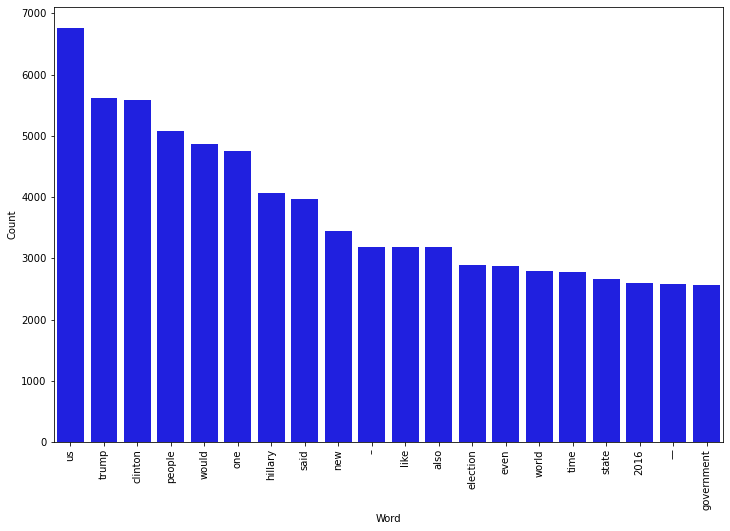

In [22]:
counter(news_df[news_df['label']=="FAKE"], "text", 20)

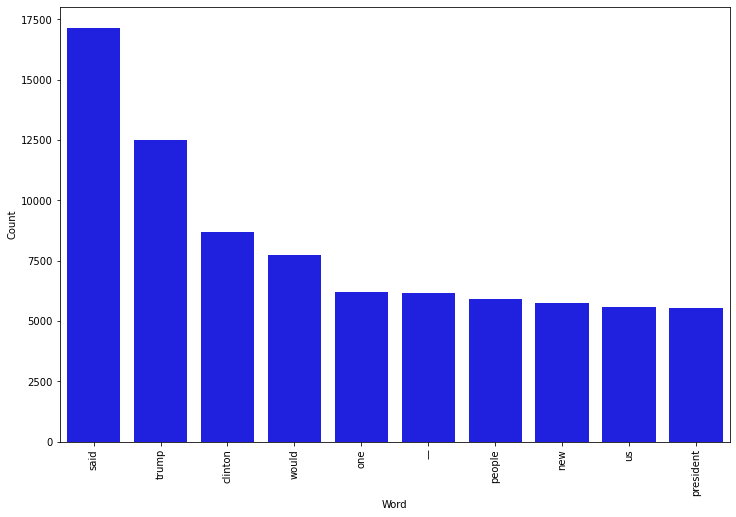

In [23]:
counter(news_df[news_df['label']=="REAL"], "text", 10)

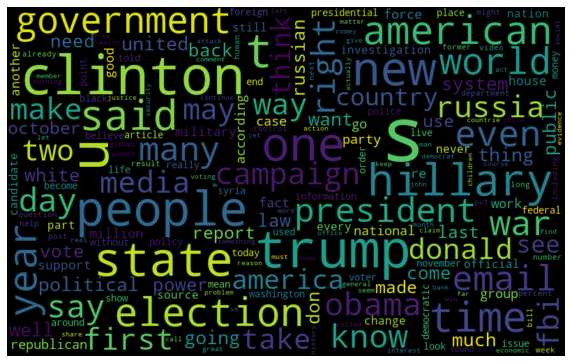

In [24]:
#wordcloud of fake news words

from wordcloud import WordCloud

fake_data = news_df[news_df['label'] == 'FAKE']
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width=800, height=500,
                         max_font_size=110,
                         collocations=False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

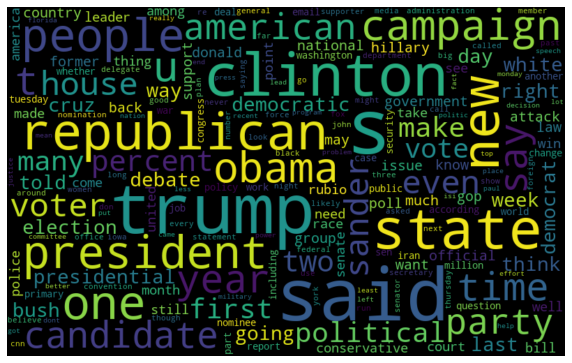

In [25]:
#word cloud for real news words
from wordcloud import WordCloud

real_data = news_df[news_df['label'] == 'REAL']
all_words = ' '.join([text for text in real_data.text])

wordcloud = WordCloud(width=800, height=500,
                         max_font_size=110,
                         collocations=False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Modelling

In [26]:
#function to plot confusion matrix
import itertools

def plot_cm(cm, classes,
            normalize=False,
            title='Confusion Matrix',
           cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j ],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
#split the data
X = news_df['text']
y = news_df.label

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
#initializing TfidfVectorizer to vectorize data

vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)
tfidf_train = vectorizer.fit_transform(X_train)
tfidf_test = vectorizer.transform(X_test)

In [32]:
#Using the PassiveAggressiveClassifier Model
from sklearn.linear_model import PassiveAggressiveClassifier

pa_classifier = PassiveAggressiveClassifier(max_iter=50)
pa_classifier.fit(tfidf_train, y_train)

PassiveAggressiveClassifier(max_iter=50)

In [33]:
#Calculating the Accuracy for the model

y_pred=pa_classifier.predict(tfidf_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 94.24%


Confusion matrix, without normalization


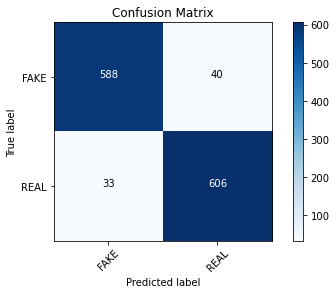

In [34]:
#plotting the confusion matrix

cm = confusion_matrix(y_test, y_pred)
plot_cm(cm, classes=['FAKE', 'REAL'])

## Testing the Model

In [35]:
def model_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test['text'] = new_def_test["text"].apply(lambda x: x.lower())
    new_def_test['text'] = new_def_test['text'].apply(string_preprocessing)
    new_x_test = new_def_test["text"]
    new_xv_test = vectorizer.transform(new_x_test)
    pred_PA = pa_classifier.predict(new_xv_test)

    
    return print("\n\nPrediction: {} ".format(output_label(pred_PA[0])))

In [ ]:
news = str(input())
testing(news)